In [603]:
import rawpy
import requests
import os
from matplotlib import pyplot as plt
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
from tqdm import tqdm

def pull_image(file_name):
    if not os.path.exists(file_name):
        !wget 'https://github.com/colour-science/colour-demosaicing-examples-datasets/raw/babef3fb4ee54971eadaa19cade72b6517a7ba16/bayer/Lighthouse.exr'
    return rawpy.imread(file_name).raw_image

def normalize(img, maxval, minval):
    """
    img: uint16 2d raw image
    out: uint8 2d normalized 0-255 image
    https://en.wikipedia.org/wiki/Normalization_(image_processing)
    """
    return (np.rint((img - img.min()) * ((maxval - minval) / (img.max() - img.min())) + minval)).astype(dtype='uint8')

(500, 500)


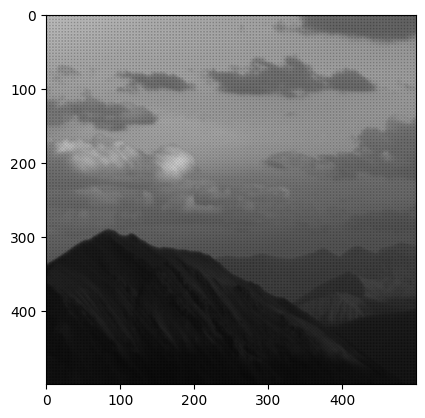

In [649]:
im = pull_image('sample.ARW')
im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
im = im[2600:3100, 2000:2500]
im = normalize(im, 255, 0)
print(im.shape)
plt.imshow(im, cmap="gray")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 2197.52it/s]


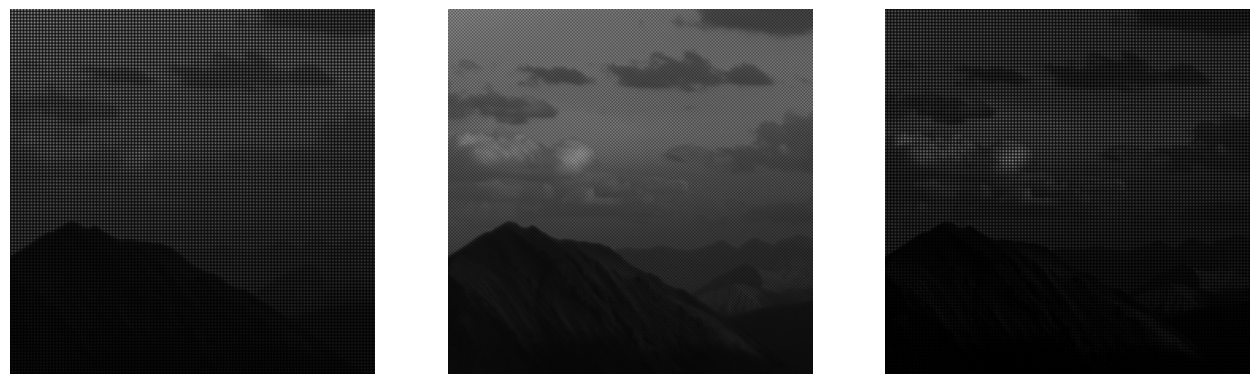

In [665]:
def applyBayer(im):
    r = np.zeros(im.shape[:2], dtype='uint8')
    g = np.zeros(im.shape[:2], dtype='uint8')
    b = np.zeros(im.shape[:2], dtype='uint8')

    for i in tqdm(range(im.shape[0]//2)):
        for j in range(im.shape[1]//2):
            i_1 = i*2
            i_2 = i*2 + 1
            j_1 = j*2
            j_2 = j*2 + 1
            g[i_1, j_1] = im[i_1, j_1]
            r[i_1, j_2] = im[i_1, j_2]
            b[i_2, j_1] = im[i_2, j_1]
            g[i_2, j_2] = im[i_2, j_2]
    return r, g, b

r, g, b = applyBayer(im)

fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.imshow(r, cmap="gray")

fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.imshow(g, cmap="gray")

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(b, cmap="gray")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 914.31it/s]


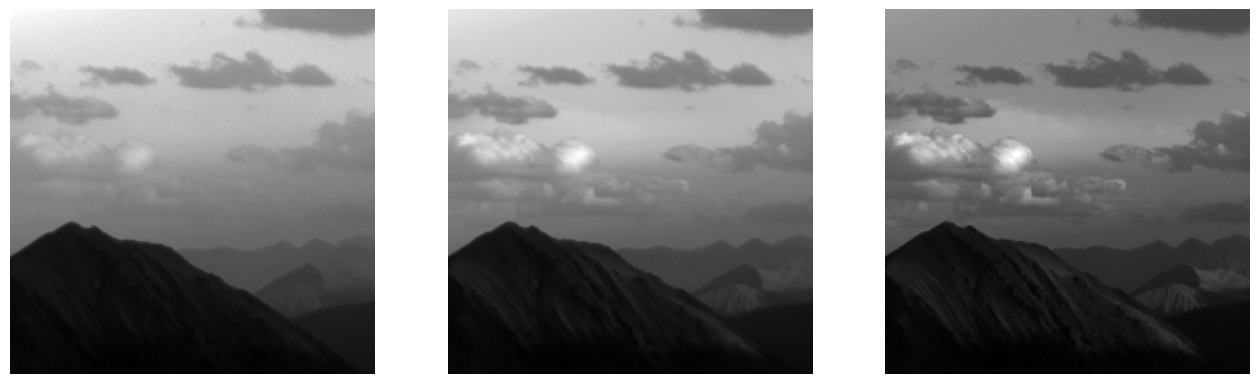

In [698]:
def applyBayerNearestNeigh(im):
    r = np.zeros(im.shape[:2], dtype='uint8')
    g = np.zeros(im.shape[:2], dtype='uint8')
    b = np.zeros(im.shape[:2], dtype='uint8')

    for i in tqdm(range(im.shape[0]//2)):
        for j in range(im.shape[1]//2):
            i_1 = i*2
            i_2 = i*2 + 1
            j_1 = j*2
            j_2 = j*2 + 1
            g[i_1, j_1] = im[i_1, j_1]
            r[i_1, j_2] = im[i_1, j_2]
            b[i_2, j_1] = im[i_2, j_1]
            g[i_2, j_2] = im[i_2, j_2]
            
            g[i_1, j_2] = g[i_1, j_1]
            g[i_2, j_1] = g[i_2, j_2]
            
            b[i_1, j_1] = b[i_2, j_1]
            b[i_1, j_2] = b[i_2, j_1]
            b[i_2, j_2] = b[i_2, j_1]
            
            r[i_1, j_1] = r[i_1, j_2]
            r[i_2, j_1] = r[i_1, j_2]
            r[i_2, j_2] = r[i_1, j_2]
    return r, g, b

r_inter, g_inter, b_inter = applyBayerNearestNeigh(im)

fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.imshow(r_inter, cmap="gray")

fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.imshow(g_inter, cmap="gray")

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(b_inter, cmap="gray")

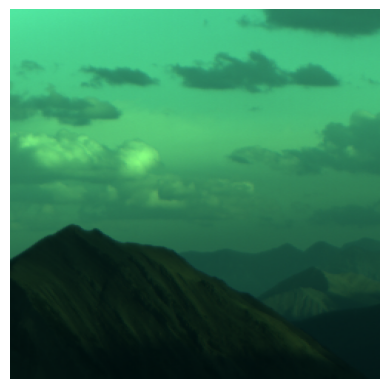

In [707]:
image = cv2.merge((b_inter,g_inter,r_inter))

plt.axis('off')
plt.imshow(image)

In [681]:
print(r[10:20, 10:20])
print("--------------")
print(r_[10:20, 10:20])

print("\n\n")

print(b[10:20, 10:20])
print("--------------")
print(b_[10:20, 10:20])

[[  0 158   0 160   0 159   0 157   0 157]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 160   0 156   0 156   0 157   0 157]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 158   0 157   0 158   0 156   0 157]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 157   0 156   0 154   0 157   0 156]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0 156   0 157   0 156   0 155   0 155]
 [  0   0   0   0   0   0   0   0   0   0]]
--------------
[[158 158 159 160 159 159 158 157 157 157]
 [158 159 158 158 157 157 157 157 157 157]
 [158 160 158 156 156 156 156 157 157 157]
 [158 159 157 156 156 157 156 156 156 157]
 [157 158 157 157 157 158 157 156 156 157]
 [157 157 157 156 156 156 156 156 156 156]
 [157 157 156 156 155 154 155 157 156 156]
 [156 156 156 156 155 155 155 156 155 155]
 [156 156 156 157 156 156 155 155 155 155]
 [155 155 155 156 156 156 155 154 154 155]]



[[ 0  0  0  0  0  0  0  0  0  0]
 [80  0 81  0 81  0 79  0 80  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [79  0 79  0 79  0 8

In [682]:
def median2d(im_2d):
    out = np.zeros(im_2d.shape, dtype='uint8')
    for i in tqdm(range(im_2d.shape[0] - 1)):
        for j in range(im_2d.shape[1] - 1):
            if im_2d[i+1,j+1] != 0:
                out[i+1,j+1] = im_2d[i+1,j+1]
            else:
                curr_k = im_2d[i:i+3, j:j+3].flatten()
                out[i+1,j+1] = np.mean(curr_k[curr_k != 0])
    return out

r_ = median2d(r)
g_ = median2d(g)
b_ = median2d(b)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:04<00:00, 100.72it/s]


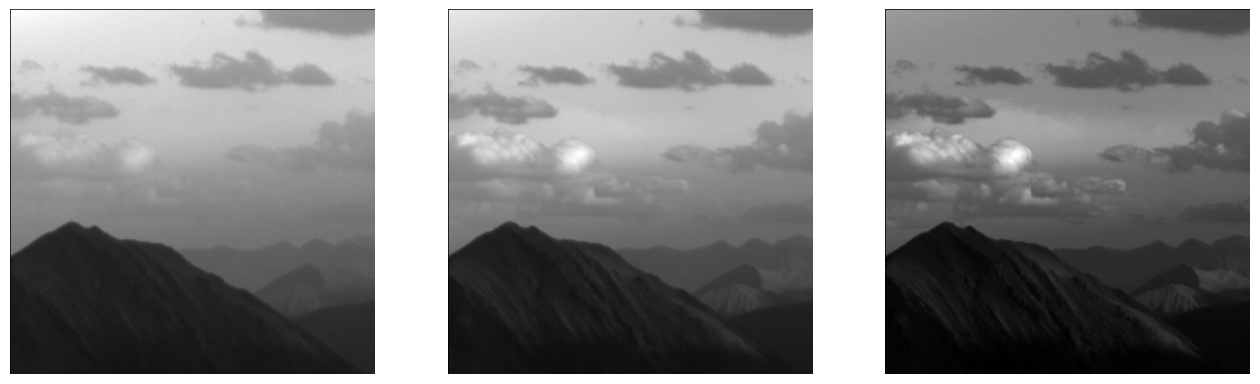

In [683]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.imshow(r_, cmap="gray")

fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.imshow(g_, cmap="gray")

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(b_, cmap="gray")

In [685]:
image = np.dstack((r,g,b))


# Window name in which image is displayed
window_name = 'image'
 
# Using cv2.imshow() method
# Displaying the image
cv2.imshow(window_name, image)
 
# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)
 
# closing all open windows
cv2.destroyAllWindows()

# cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
# plt.imshow(image)